# Baseline Models Template for 2016 - 2020 Data (exports)
Tidying up "4_baseline_model_export_targetEncoding" as well as adding in resampling options

## Setup

In [1]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from imodels import FIGSClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
# sklearn
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
#from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_feature_importances

# create folders and export models
import joblib
import os

In [2]:
# environment variables
rng = 42
p = '../data/'
input_name = 'cleaned.csv'
# change this value to False if you don't want printouts after every model
outputs = True

# set up folder to save results
output_path = 'export_run5_TargetEncoding_resampling'
if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")
# file name
prefix = 'export_run5_TargetEncoding_resampling/export'

Folder already exists


In [3]:
# helper functions
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]

    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y)

    return X_train, X_test, y_train, y_test

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

def plot_pca(pca, f_names, top_k = 10):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()

def upsampler(df_x, df_y): # https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
    # combine results
    df_x['act'] = df_y
    # filter into majority / minority
    df_majority = df_x.loc[df_x['act']==0]
    df_minority = df_x.loc[df_x['act']==1]
    # upsample to the size of the majority
    df_minority_upsampled = resample(df_minority, replace=True, n_samples= len(df_majority), random_state=rng)
    # combine and split back into x and y dfs
    df_upsampled = pd.concat([df_minority_upsampled, df_majority])
    new_y = df_upsampled['act']
    new_x = df_upsampled.drop(columns=['act'])
    return new_x, new_y

#### Preprocessing

In [4]:
# read in the data
df = pd.read_csv(f'{p}{input_name}')
if outputs:
    print(df.columns)

Index(['control_number', 'species_code', 'genus', 'species', 'wildlf_desc',
       'wildlf_cat', 'cartons', 'qty', 'unit', 'value', 'ctry_org', 'ctry_ie',
       'purp', 'src', 'trans_mode', 'act', 'dp_cd', 'disp_date', 'ship_date',
       'i_e', 'pt_cd', 'specific_generic_name', 'disp_date_yyyy',
       'disp_date_mm', 'ship_date_yyyy', 'ship_date_mm', 'disp_ship_date'],
      dtype='object')


In [5]:
# modify these columns to adjust what features are used
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date',
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

In [6]:
#import_df = df_filtering(df, i_e = 'I', f_cols = feature_cols)
export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 590505 rows × 11 columns
# export: 299340 rows × 11 columns

In [7]:
# standard version of the data
X_train, X_test, y_train, y_test = data_split(export_df)

In [8]:
# resampled version of the data (not CV)
X_train_resampled, y_train_resampled = upsampler(X_train.copy(),y_train.copy())

#### column transformer w/ TargetEncoding

In [1]:
from category_encoders.target_encoder import TargetEncoder

In [2]:
categorical_var = ['species_code', 'wildlf_desc', 'ctry_org', 'ctry_ie','purp', 'src', 
                   'trans_mode', 'pt_cd','ship_date_mm']
numerical_var = ['value']

In [11]:
ct_target = make_column_transformer(
    (StandardScaler(), numerical_var),
    (TargetEncoder(), categorical_var),
    remainder='passthrough')
le = LabelEncoder()

C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [12]:
X_train = ct_target.fit_transform(X_train, y_train)
#joblib.dump(X_train, 'X_train_targetEncoding.joblib')

X_test = ct_target.transform(X_test)
#joblib.dump(X_test, 'X_test_targetEncoding.joblib')
# Found unknown categories

X_train_resampled = ct_target.transform(X_train_resampled)
#joblib.dump(X_train_resampled, 'X_train_targetEncoding_resampled.joblib')

C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


['X_train_targetEncoding_resampled.joblib']

In [13]:
# SMOTE version of the data on target encoded (not CV)
sm = SMOTE(sampling_strategy='minority', random_state=rng)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)

## Modeling Standard Target Encoded Data

#### Dummy Classifers

In [14]:
start = datetime.now()
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted = dummy_majority.predict(X_test)

model run time: 0:00:00.005511


In [15]:
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf.joblib')

['export_run5_TargetEncoding_resampling/export_dummy_majority_clf.joblib']

#### Logistic Regression

model run time: 0:00:01.202965
Logistic regression classifier (default settings)
 [[   75   568]
 [   30 74162]]


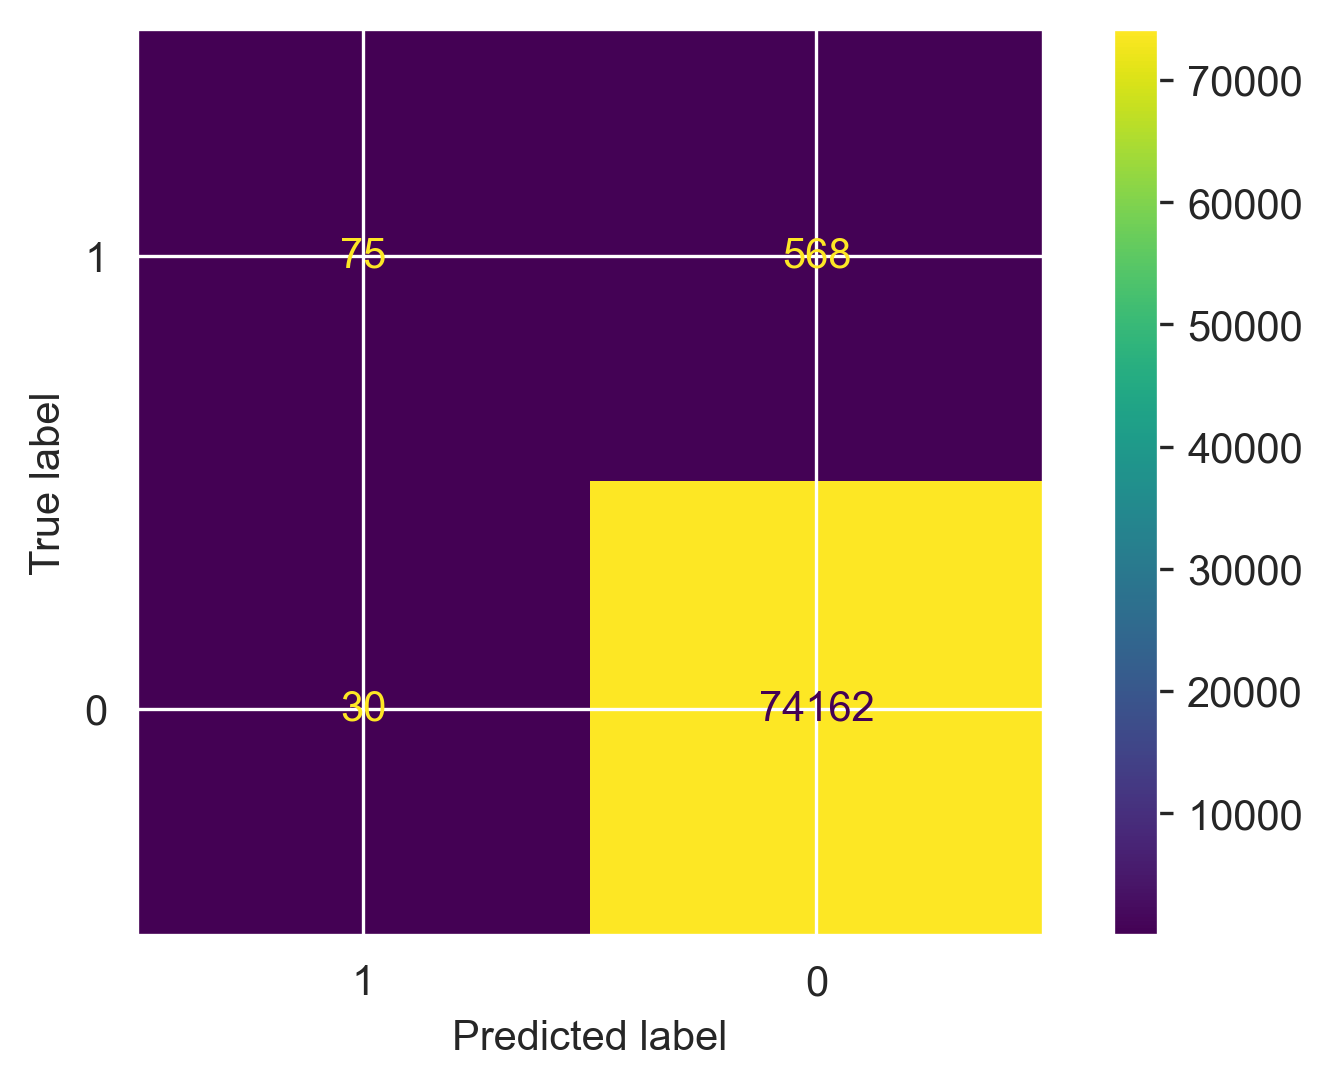

In [16]:
start = datetime.now()
lr = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

lr_predicted = lr.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted, labels = [1,0])
if outputs:
    print('Logistic regression classifier (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [17]:
start = datetime.now()
lr_balanced = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

lr_balanced_predicted = lr_balanced.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted)
if outputs:
    print('Logistic regression classifier (balanced)\n', confusion)

model run time: 0:00:01.303410
Logistic regression classifier (balanced)
 [[67702  6490]
 [  295   348]]


In [18]:
joblib.dump(lr, f'{prefix}_lr_clf.joblib')
joblib.dump(lr_balanced, f'{prefix}_lr_balanced_clf.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf.joblib']

#### Decision Tree

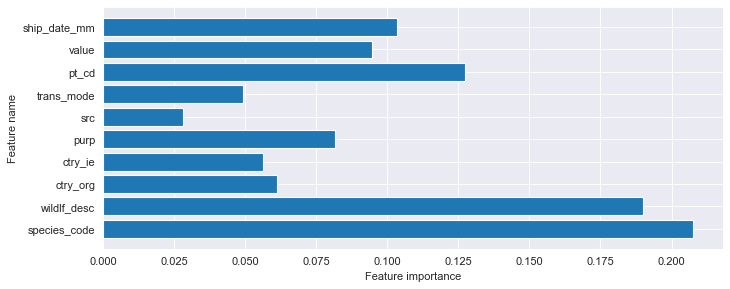

Feature importances: [0.1034151  0.09471394 0.12736673 0.04938061 0.02818066 0.081759
 0.05633878 0.06116747 0.18996441 0.20771333]


In [21]:
start = datetime.now()
decision_tree_clf = DecisionTreeClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted = decision_tree_clf.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted)
if outputs:
    print('Decision Tree classifier (balanced)\n', confusion)
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(decision_tree_clf, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf.feature_importances_[::-1]))

In [22]:
joblib.dump(decision_tree_clf, f'{prefix}_decision_tree_clf.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf.joblib']

#### Random Forest

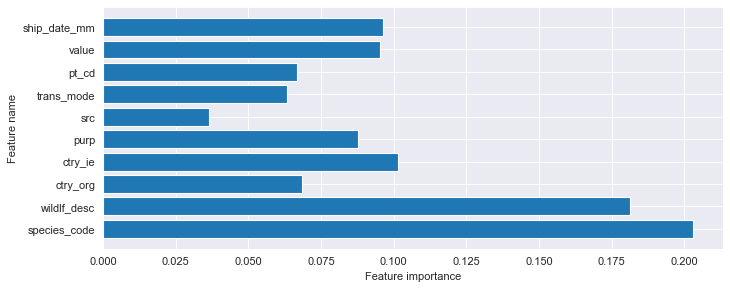

Feature importances: [0.09635666 0.09526445 0.06666391 0.06341149 0.03632125 0.08788921
 0.10143157 0.06837879 0.18115329 0.20312939]


In [26]:
start = datetime.now()
rf_clf = RandomForestClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted = rf_clf.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted)
if outputs:
    print('Random Forest classifier (balanced)\n', confusion)
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(rf_clf, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf.feature_importances_[::-1]))

In [25]:
joblib.dump(rf_clf, f'{prefix}_rf_clf.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf.joblib']

#### XGBoost Classifier
(default settings)

In [28]:
start = datetime.now()
xgb_params = {"seed": rng }
xgb_clf = xgb.XGBClassifier(random_state = rng).fit(X_train,y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted = xgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted)
if outputs:
    print('XGB Classifier Confusion Matrix\n', confusion)

XGB Classifier Confusion Matrix
 [[74151    41]
 [  419   224]]


In [29]:
joblib.dump(rf_clf, f'{prefix}_xgb_clf.joblib')

['export_run5_TargetEncoding_resampling/export_xgb_clf.joblib']

#### FIGS

In [31]:
start = datetime.now()
figs_clf = FIGSClassifier(random_state=rng).fit(X_train,y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted = figs_clf.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted)
if outputs:
    print('FIGS Classifier Confusion Matrix\n', confusion)

FIGS Classifier Confusion Matrix
 [[74157    35]
 [  469   174]]


In [32]:
joblib.dump(rf_clf, f'{prefix}_figs_clf.joblib')

['export_run5_TargetEncoding_resampling/export_figs_clf.joblib']

#### LGBM

In [34]:
# light gbm with default params (this thing has a LOT of customization options fyi)
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
start = datetime.now()
lgbm_model = lgb.LGBMClassifier().fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted = lgbm_model.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted)
if outputs:
    print('LightLGBM Classifier Confusion Matrix\n', confusion)

LightLGBM Classifier Confusion Matrix
 [[74079   113]
 [  444   199]]


In [35]:
joblib.dump(rf_clf, f'{prefix}_lgbm_clf.joblib')

['export_run5_TargetEncoding_resampling/export_lgbm_clf.joblib']

#### Model Evaluation

In [36]:
if outputs:
    print('Most frequent class (dummy classifier) \n',
          classification_report(y_test, dummy_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression \n',
          classification_report(y_test, lr_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression (balanced) \n',
          classification_report(y_test, lr_balanced_predicted, target_names=['clear', 'seized']))
    print('Decision Tree \n',
          classification_report(y_test, tree_predicted, target_names=['clear', 'seized']))
    print('Random Forest \n',
          classification_report(y_test, rf_predicted, target_names=['clear', 'seized']))
    print('XGBoost Classifier \n',
          classification_report(y_test, xgb_predicted, target_names=['clear', 'seized']))
    print('FIGS Classifier \n',
          classification_report(y_test, figs_predicted, target_names=['clear', 'seized']))
    print("LGBM Classifier \n",
          classification_report(y_test, lgbm_predicted, target_names=['clear', 'seized']))

Most frequent class (dummy classifier) 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.00      0.00      0.00       643

    accuracy                           0.99     74835
   macro avg       0.50      0.50      0.50     74835
weighted avg       0.98      0.99      0.99     74835

Logistic Regression 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.71      0.12      0.20       643

    accuracy                           0.99     74835
   macro avg       0.85      0.56      0.60     74835
weighted avg       0.99      0.99      0.99     74835



C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression (balanced) 
               precision    recall  f1-score   support

       clear       1.00      0.91      0.95     74192
      seized       0.05      0.54      0.09       643

    accuracy                           0.91     74835
   macro avg       0.52      0.73      0.52     74835
weighted avg       0.99      0.91      0.94     74835

Decision Tree 
               precision    recall  f1-score   support

       clear       1.00      1.00      1.00     74192
      seized       0.46      0.45      0.45       643

    accuracy                           0.99     74835
   macro avg       0.73      0.72      0.72     74835
weighted avg       0.99      0.99      0.99     74835

Random Forest 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.75      0.42      0.54       643

    accuracy                           0.99     74835
   macro avg       0.87      0.71      0.77     74835
weighted 

In [37]:
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)

## Resampled Data

In [38]:
# dummy classifier
start = datetime.now()
dummy_majority_resampled = DummyClassifier(strategy = 'most_frequent').fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted_resampled = dummy_majority_resampled.predict(X_test)
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf_resampled.joblib')

model run time: 0:00:00.011086


['export_run5_TargetEncoding_resampling/export_dummy_majority_clf_resampled.joblib']

model run time: 0:00:03.662190
Logistic regression classifier resampled (default settings)
 [[  355   288]
 [ 6998 67194]]


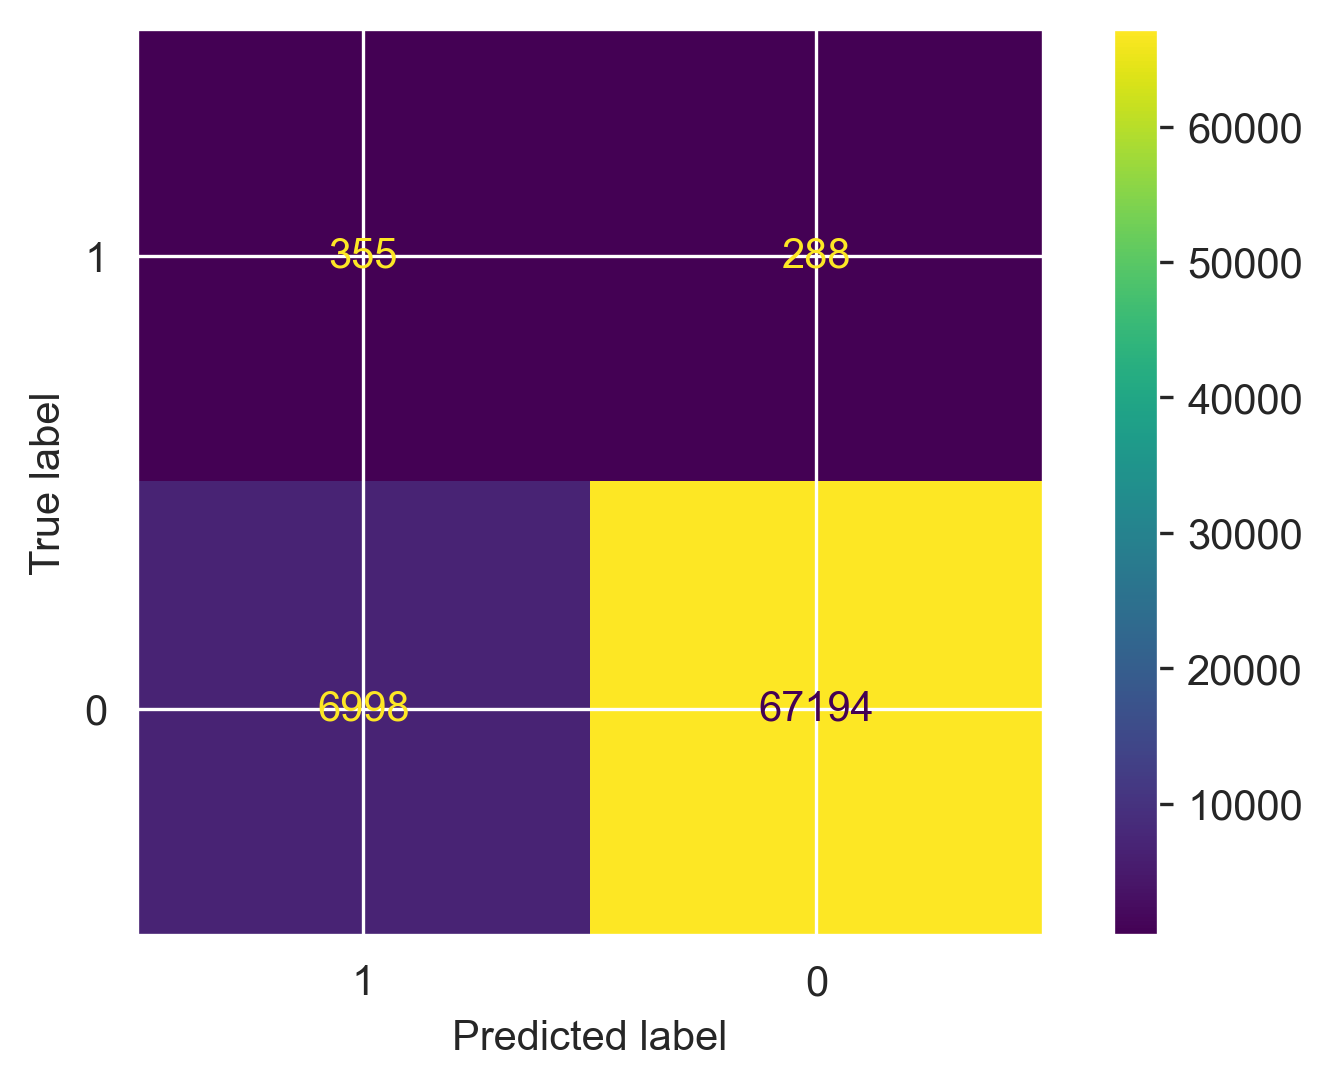

In [39]:
# logistic regression
start = datetime.now()
lr_resampled = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_predicted_resampled = lr_resampled.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted_resampled, labels=[1, 0])
if outputs:
    print('Logistic regression classifier resampled (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1, 0])
if outputs:
    cm_display.plot()

In [40]:
# balanced logistic regression
start = datetime.now()
lr_balanced_resampled = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_balanced_predicted_resampled = lr_balanced.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted_resampled)
if outputs:
    print('Logistic regression classifier resampled (balanced)\n', confusion)

model run time: 0:00:03.781091
Logistic regression classifier resampled (balanced)
 [[67702  6490]
 [  295   348]]


In [41]:
joblib.dump(lr_resampled, f'{prefix}_lr_clf_resampled.joblib')
joblib.dump(lr_balanced_resampled, f'{prefix}_lr_balanced_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf_resampled.joblib']

model run time: 0:00:00.930136
Decision Tree classifier resampled
 [[73879   313]
 [  388   255]]


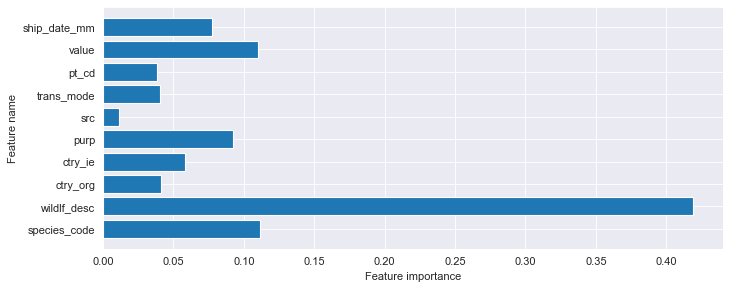

Feature importances: [0.0776644  0.11012274 0.03809846 0.04015594 0.01103578 0.09200006
 0.0581536  0.04150631 0.41938353 0.11187918]


In [42]:
# decision tree
start = datetime.now()
decision_tree_clf_resampled = DecisionTreeClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted_resampled = decision_tree_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted_resampled)
if outputs:
    print('Decision Tree classifier resampled\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(decision_tree_clf_resampled, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf_resampled.feature_importances_[::-1]))

In [43]:
joblib.dump(decision_tree_clf_resampled, f'{prefix}_decision_tree_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf_resampled.joblib']

model run time: 0:00:26.727858
Random Forest classifier (balanced)
 [[74036   156]
 [  371   272]]


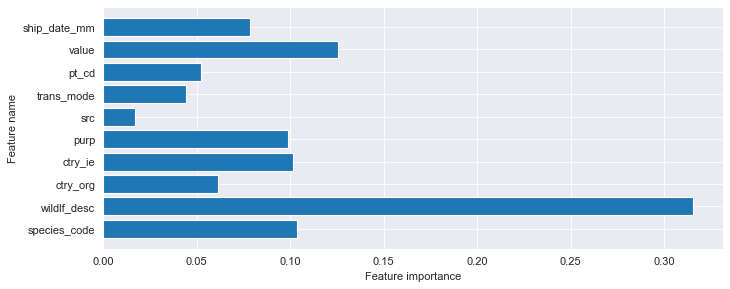

Feature importances: [0.07856192 0.12584312 0.05238165 0.04457253 0.01714821 0.09877354
 0.10168859 0.06158398 0.31564597 0.10380049]


In [44]:
# random forest
start = datetime.now()
rf_clf_resampled = RandomForestClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted_resampled = rf_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_resampled)
if outputs:
    print('Random Forest classifier (balanced)\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(rf_clf_resampled, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf_resampled.feature_importances_[::-1]))

In [45]:
joblib.dump(rf_clf, f'{prefix}_rf_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf_resampled.joblib']

In [46]:
# xgboost
start = datetime.now()
xgb_params = {"seed": rng}
xgb_clf_resampled = xgb.XGBClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted_resampled = xgb_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted_resampled)
if outputs:
    print('XGB Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf_resampled, f'{prefix}_xgb_clf_resampled.joblib')

[22:42:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\joshh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model run time: 0:00:04.695704
XGB Classifier Resampled Confusion Matrix
 [[71397  2795]
 [  272   371]]


['export_run5_TargetEncoding_resampling/export_xgb_clf_resampled.joblib']

In [47]:
# figs
start = datetime.now()
figs_clf_resampled = FIGSClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted_resampled = figs_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted_resampled)
if outputs:
    print('FIGS Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_figs_clf_resampled.joblib')

model run time: 0:00:13.473461
FIGS Classifier Resampled Confusion Matrix
 [[61062 13130]
 [  235   408]]


['export_run5_TargetEncoding_resampling/export_figs_clf_resampled.joblib']

In [48]:
#lightgbm
start = datetime.now()
lgbm_model_resampled = lgb.LGBMClassifier().fit(X_train_resampled, y_train_resampled, eval_set=[(X_test, y_test),
                                                                                      (X_train_resampled, y_train_resampled)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted_resampled = lgbm_model_resampled.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted_resampled)
if outputs:
    print('LightLGBM Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_lgbm_clf_resampled.joblib')

[1]	training's binary_logloss: 0.640436	valid_0's binary_logloss: 0.641452
[2]	training's binary_logloss: 0.597086	valid_0's binary_logloss: 0.598867
[3]	training's binary_logloss: 0.560913	valid_0's binary_logloss: 0.563358
[4]	training's binary_logloss: 0.530109	valid_0's binary_logloss: 0.5331
[5]	training's binary_logloss: 0.503827	valid_0's binary_logloss: 0.507489
[6]	training's binary_logloss: 0.479967	valid_0's binary_logloss: 0.48384
[7]	training's binary_logloss: 0.459746	valid_0's binary_logloss: 0.46367
[8]	training's binary_logloss: 0.441787	valid_0's binary_logloss: 0.446019
[9]	training's binary_logloss: 0.42581	valid_0's binary_logloss: 0.430115
[10]	training's binary_logloss: 0.411333	valid_0's binary_logloss: 0.415911
[11]	training's binary_logloss: 0.39832	valid_0's binary_logloss: 0.403181
[12]	training's binary_logloss: 0.386786	valid_0's binary_logloss: 0.391729
[13]	training's binary_logloss: 0.376408	valid_0's binary_logloss: 0.381867
[14]	training's binary_logl

['export_run5_TargetEncoding_resampling/export_lgbm_clf_resampled.joblib']

## SMOTE Data

In [49]:
# dummy classifier
start = datetime.now()
dummy_majority_smote = DummyClassifier(strategy = 'most_frequent').fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted_smote = dummy_majority_smote.predict(X_test)
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf_smote.joblib')

model run time: 0:00:00.013472


['export_run5_TargetEncoding_resampling/export_dummy_majority_clf_smote.joblib']

model run time: 0:00:04.079395
Logistic regression classifier SMOTE (default settings)
 [[  357   286]
 [ 7155 67037]]


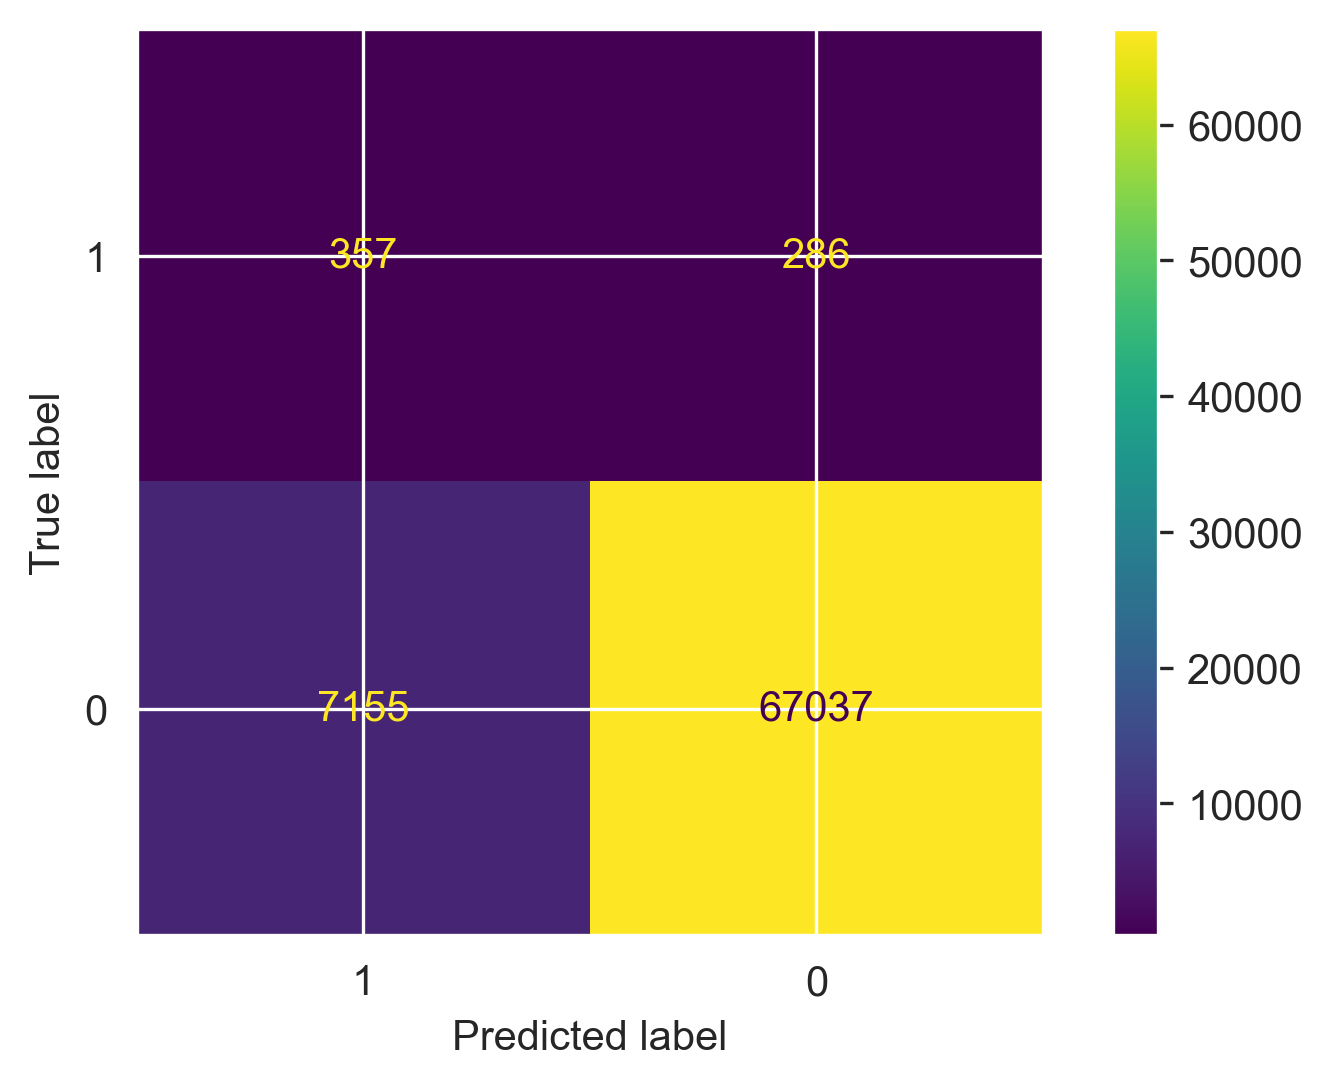

In [50]:
# logistic regression
start = datetime.now()
lr_smote = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_predicted_smote = lr_smote.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted_smote, labels=[1, 0])
if outputs:
    print('Logistic regression classifier SMOTE (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1, 0])
if outputs:
    cm_display.plot()

In [51]:
# balanced logistic regression
start = datetime.now()
lr_balanced_smote = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(
    X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_balanced_predicted_smote = lr_balanced_smote.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted_smote)
if outputs:
    print('Logistic regression classifier SMOTE (balanced)\n', confusion)

model run time: 0:00:04.056923
Logistic regression classifier SMOTE (balanced)
 [[67037  7155]
 [  286   357]]


In [52]:
joblib.dump(lr_smote, f'{prefix}_lr_clf_smote.joblib')
joblib.dump(lr_balanced_smote, f'{prefix}_lr_balanced_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf_smote.joblib']

model run time: 0:00:02.253601
Decision Tree classifier SMOTE
 [[73680   512]
 [  366   277]]


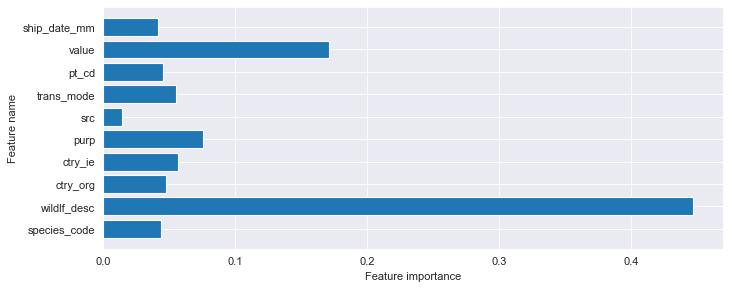

Feature importances: [0.04166059 0.1713789  0.04565472 0.05541097 0.01445036 0.07561073
 0.05691768 0.04764924 0.44739133 0.04387547]


In [53]:
# decision tree
start = datetime.now()
decision_tree_clf_smote = DecisionTreeClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted_smote = decision_tree_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted_smote)
if outputs:
    print('Decision Tree classifier SMOTE\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(decision_tree_clf_smote, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf_smote.feature_importances_[::-1]))

In [54]:
joblib.dump(decision_tree_clf_smote, f'{prefix}_decision_tree_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf_smote.joblib']

model run time: 0:00:47.391396
Logistic regression classifier (balanced)
 [[74015   177]
 [  354   289]]


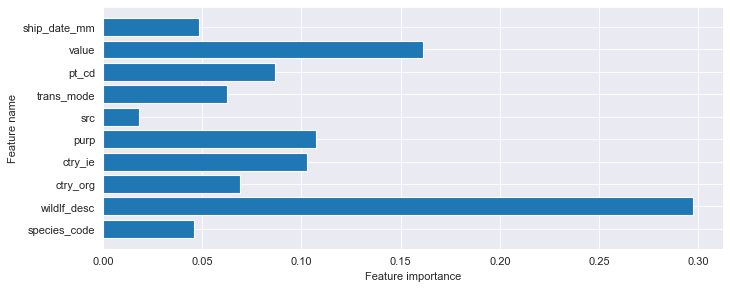

Feature importances: [0.04851433 0.16144691 0.08651249 0.06269804 0.01796376 0.10750109
 0.10268448 0.06924305 0.29757459 0.04586125]


In [55]:
# random forest
start = datetime.now()
rf_clf_smote = RandomForestClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted_smote = rf_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_smote)
if outputs:
    print('Logistic regression classifier (balanced)\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(rf_clf_smote, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf_smote.feature_importances_[::-1]))

In [56]:
joblib.dump(rf_clf, f'{prefix}_rf_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf_smote.joblib']

In [57]:
# xgboost
start = datetime.now()
xgb_params = {"seed": rng}
xgb_clf_smote = xgb.XGBClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted_smote = xgb_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted_smote)
if outputs:
    print('XGB Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf_smote, f'{prefix}_xgb_clf_resampled.joblib')

C:\Users\joshh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:43:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model run time: 0:00:08.332176
XGB Classifier SMOTE Confusion Matrix
 [[73626   566]
 [  342   301]]


['export_run5_TargetEncoding_resampling/export_xgb_clf_resampled.joblib']

In [58]:
# figs
start = datetime.now()
figs_clf_smote = FIGSClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted_smote = figs_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted_smote)
if outputs:
    print('FIGS Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_figs_clf_smote.joblib')

model run time: 0:00:18.186968
FIGS Classifier SMOTE Confusion Matrix
 [[64467  9725]
 [  284   359]]


['export_run5_TargetEncoding_resampling/export_figs_clf_smote.joblib']

In [59]:
#lightgbm
start = datetime.now()
lgbm_model_smote = lgb.LGBMClassifier().fit(X_train_SMOTE, y_train_SMOTE, eval_set=[(X_test, y_test),
                                                                                    (X_train_SMOTE, y_train_SMOTE)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted_smote = lgbm_model_smote.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted_smote)
if outputs:
    print('LightLGBM Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_lgbm_clf_smote.joblib')

[1]	training's binary_logloss: 0.632419	valid_0's binary_logloss: 0.633205
[2]	training's binary_logloss: 0.583411	valid_0's binary_logloss: 0.585307
[3]	training's binary_logloss: 0.541586	valid_0's binary_logloss: 0.544074
[4]	training's binary_logloss: 0.505381	valid_0's binary_logloss: 0.508587
[5]	training's binary_logloss: 0.474014	valid_0's binary_logloss: 0.47793
[6]	training's binary_logloss: 0.44598	valid_0's binary_logloss: 0.45084
[7]	training's binary_logloss: 0.420805	valid_0's binary_logloss: 0.426724
[8]	training's binary_logloss: 0.398979	valid_0's binary_logloss: 0.405872
[9]	training's binary_logloss: 0.379669	valid_0's binary_logloss: 0.386986
[10]	training's binary_logloss: 0.36188	valid_0's binary_logloss: 0.369729
[11]	training's binary_logloss: 0.346036	valid_0's binary_logloss: 0.35472
[12]	training's binary_logloss: 0.331462	valid_0's binary_logloss: 0.340525
[13]	training's binary_logloss: 0.318182	valid_0's binary_logloss: 0.327432
[14]	training's binary_log

['export_run5_TargetEncoding_resampling/export_lgbm_clf_smote.joblib']

## Overall Data Comparison

In [60]:
if outputs:
    # dummy
    print('Most frequent class standard(dummy classifier) \n',
          classification_report(y_test, dummy_predicted, target_names=['clear', 'seized']))
    print('Most frequent class resampled (dummy classifier) \n',
          classification_report(y_test, dummy_predicted_resampled, target_names=['clear', 'seized']))
    print('Most frequent class SMOTE (dummy classifier) \n',
          classification_report(y_test, dummy_predicted_smote, target_names=['clear', 'seized']))\
    # logistic regression
    print('Logistic Regression standard \n',
          classification_report(y_test, lr_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression resampled \n',
          classification_report(y_test, lr_predicted_resampled, target_names=['clear', 'seized']))
    print('Logistic Regression SMOTE \n',
          classification_report(y_test, lr_predicted_smote, target_names=['clear', 'seized']))
    # logistic regression balanced
    print('Logistic Regression (balanced) \n',
          classification_report(y_test, lr_balanced_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression resampled (balanced) \n',
          classification_report(y_test, lr_balanced_predicted_resampled, target_names=['clear', 'seized']))
    print('Logistic Regression SMOTE (balanced) \n',
          classification_report(y_test, lr_balanced_predicted_smote, target_names=['clear', 'seized']))
    # decision tree
    print('Decision Tree \n',
          classification_report(y_test, tree_predicted, target_names=['clear', 'seized']))
    print('Decision Tree resampled \n',
          classification_report(y_test, tree_predicted_resampled, target_names=['clear', 'seized']))
    print('Decision Tree SMOTE \n',
          classification_report(y_test, tree_predicted_smote, target_names=['clear', 'seized']))
    # random forest
    print('Random Forest \n',
          classification_report(y_test, rf_predicted, target_names=['clear', 'seized']))
    print('Random Forest resampled \n',
          classification_report(y_test, rf_predicted_resampled, target_names=['clear', 'seized']))
    print('Random Forest SMOTE \n',
          classification_report(y_test, rf_predicted_smote, target_names=['clear', 'seized']))
    # XGBoost
    print('XGBoost Classifier \n',
          classification_report(y_test, xgb_predicted, target_names=['clear', 'seized']))
    print('XGBoost Classifier resampled \n',
          classification_report(y_test, xgb_predicted_resampled, target_names=['clear', 'seized']))
    print('XGBoost Classifier SMOTE \n',
          classification_report(y_test, xgb_predicted_resampled, target_names=['clear', 'seized']))
    # FIGS
    print('FIGS Classifier \n',
          classification_report(y_test, figs_predicted, target_names=['clear', 'seized']))
    print('FIGS Classifier resampled\n',
          classification_report(y_test, figs_predicted_resampled, target_names=['clear', 'seized']))
    print('FIGS Classifier SMOTE\n',
          classification_report(y_test, figs_predicted_smote, target_names=['clear', 'seized']))
    # LGBM
    print("LGBM Classifier \n",
          classification_report(y_test, lgbm_predicted, target_names=['clear', 'seized']))
    print("LGBM Classifier resampled \n",
          classification_report(y_test, lgbm_predicted_resampled, target_names=['clear', 'seized']))
    print("LGBM Classifier SMOTE \n",
          classification_report(y_test, lgbm_predicted_smote, target_names=['clear', 'seized']))

Most frequent class standard(dummy classifier) 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.00      0.00      0.00       643

    accuracy                           0.99     74835
   macro avg       0.50      0.50      0.50     74835
weighted avg       0.98      0.99      0.99     74835



C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joshh\anaconda3\lib\site-packages\sklearn\metr

Most frequent class resampled (dummy classifier) 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.00      0.00      0.00       643

    accuracy                           0.99     74835
   macro avg       0.50      0.50      0.50     74835
weighted avg       0.98      0.99      0.99     74835

Most frequent class SMOTE (dummy classifier) 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.00      0.00      0.00       643

    accuracy                           0.99     74835
   macro avg       0.50      0.50      0.50     74835
weighted avg       0.98      0.99      0.99     74835

Logistic Regression standard 
               precision    recall  f1-score   support

       clear       0.99      1.00      1.00     74192
      seized       0.71      0.12      0.20       643

    accuracy                           0.99     74835